In [1]:
using DIVAnd
using PyPlot
using NCDatasets
using Missings
using Interpolations
using Plots

if VERSION >= v"0.7"
    using Random
    using DelimitedFiles
    using Statistics
    using Printf
    using FileIO
else
    using Compat: @info, @warn, range, cat
end

include("../src/make_fishs_products.jl");

In [2]:
fishdatadir = "/home/ctroupin/tmp/Emodnet-Bio/Olivier-Fish/"
datafileS = joinpath(fishdatadir, "Fish_spa_abs.csv");

## Data reading
We use the function `read_fish` define in the module `make_benthos_products.jl`.

In [3]:
@time obslonS, obslatS, obsyearS, g1S, g2S, g3S, g4S = read_fish(datafileS);
@info extrema(obslonS)
@info extrema(obslatS)

┌ Info: Working on a temporal data file
└ @ Main /home/ctroupin/ULg/Tools/DIVAndNN/src/make_fishs_products.jl:30
┌ Info: Number of data points: 37595
└ @ Main /home/ctroupin/ULg/Tools/DIVAndNN/src/make_fishs_products.jl:46


  3.592886 seconds (12.51 M allocations: 412.914 MiB, 6.16% gc time)
  0.736902 seconds (5.57 M allocations: 141.676 MiB, 3.18% gc time)


┌ Info: Working on a spatial data file
└ @ Main /home/ctroupin/ULg/Tools/DIVAndNN/src/make_fishs_products.jl:34
┌ Info: Number of data points: 37739
└ @ Main /home/ctroupin/ULg/Tools/DIVAndNN/src/make_fishs_products.jl:46
┌ Info: (-15.9157, 22.2)
└ @ Main In[3]:3
┌ Info: (36.0013, 61.8833)
└ @ Main In[3]:4


### Mask and metrics

In [4]:
xi,yi = DIVAnd.ndgrid(gridlonFish, gridlatFish);
pm = ones(size(xi)) / (xi[2,1]-xi[1,1]);
pn = ones(size(xi)) / (yi[1,2]-yi[1,1]);

#### Extract the mask from the bathymetry

In [6]:
topodir = "../data/"
topofile = joinpath(topodir, "gebco_30sec_8.nc");

if isfile(topofile)
    bx, by, b = DIVAnd.load_bath(topofile,true,gridlonFish, gridlatFish);
    xmask, ymask, mmask = DIVAnd.load_mask(topofile,true,gridlonFish, gridlatFish,[0]);
else
    @error "Bathymetry file doesn't exist"
end
mmask = mmask[:,:,1]
@info size(mmask)

┌ Info: (391, 261)
└ @ Main In[6]:11


#### Plot mask

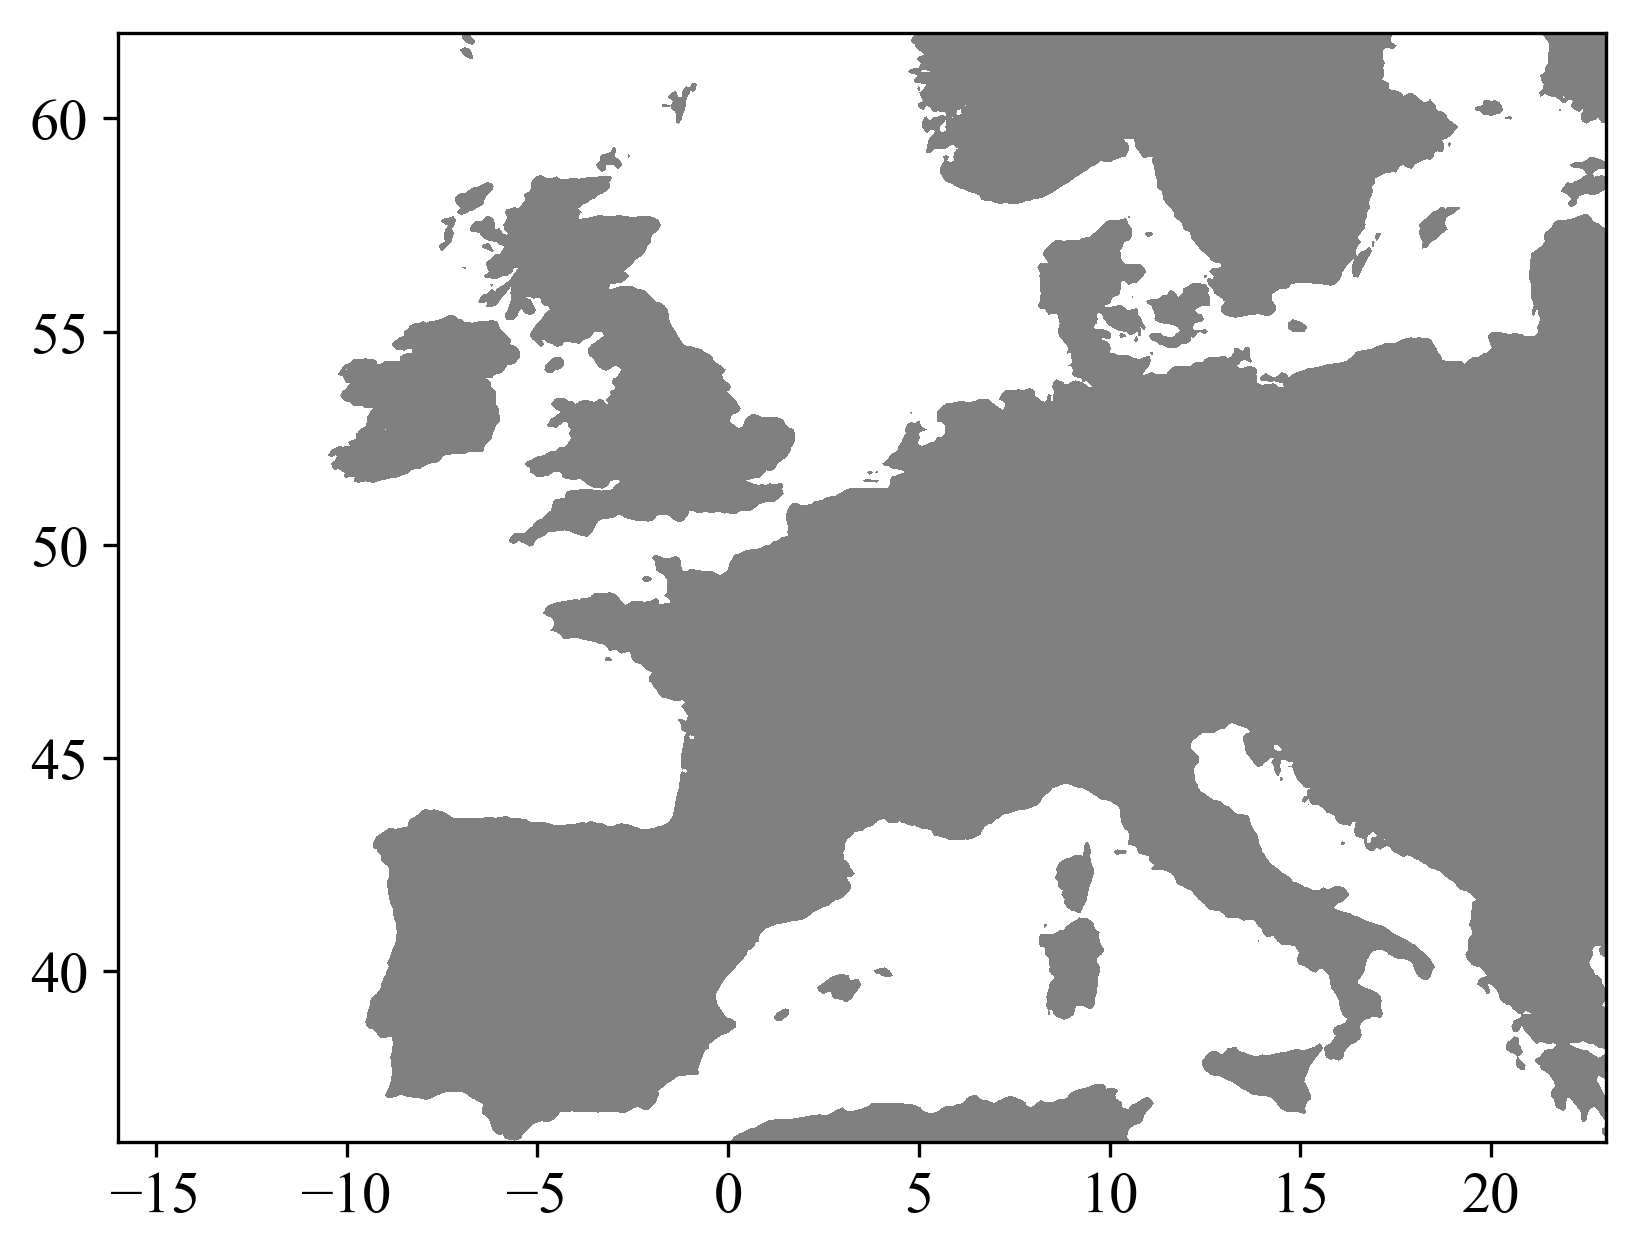

PyObject <matplotlib.contour.QuadContourSet object at 0x7f743b1313c8>

In [7]:
add_mask(bx, by, b)

### Plot the data values

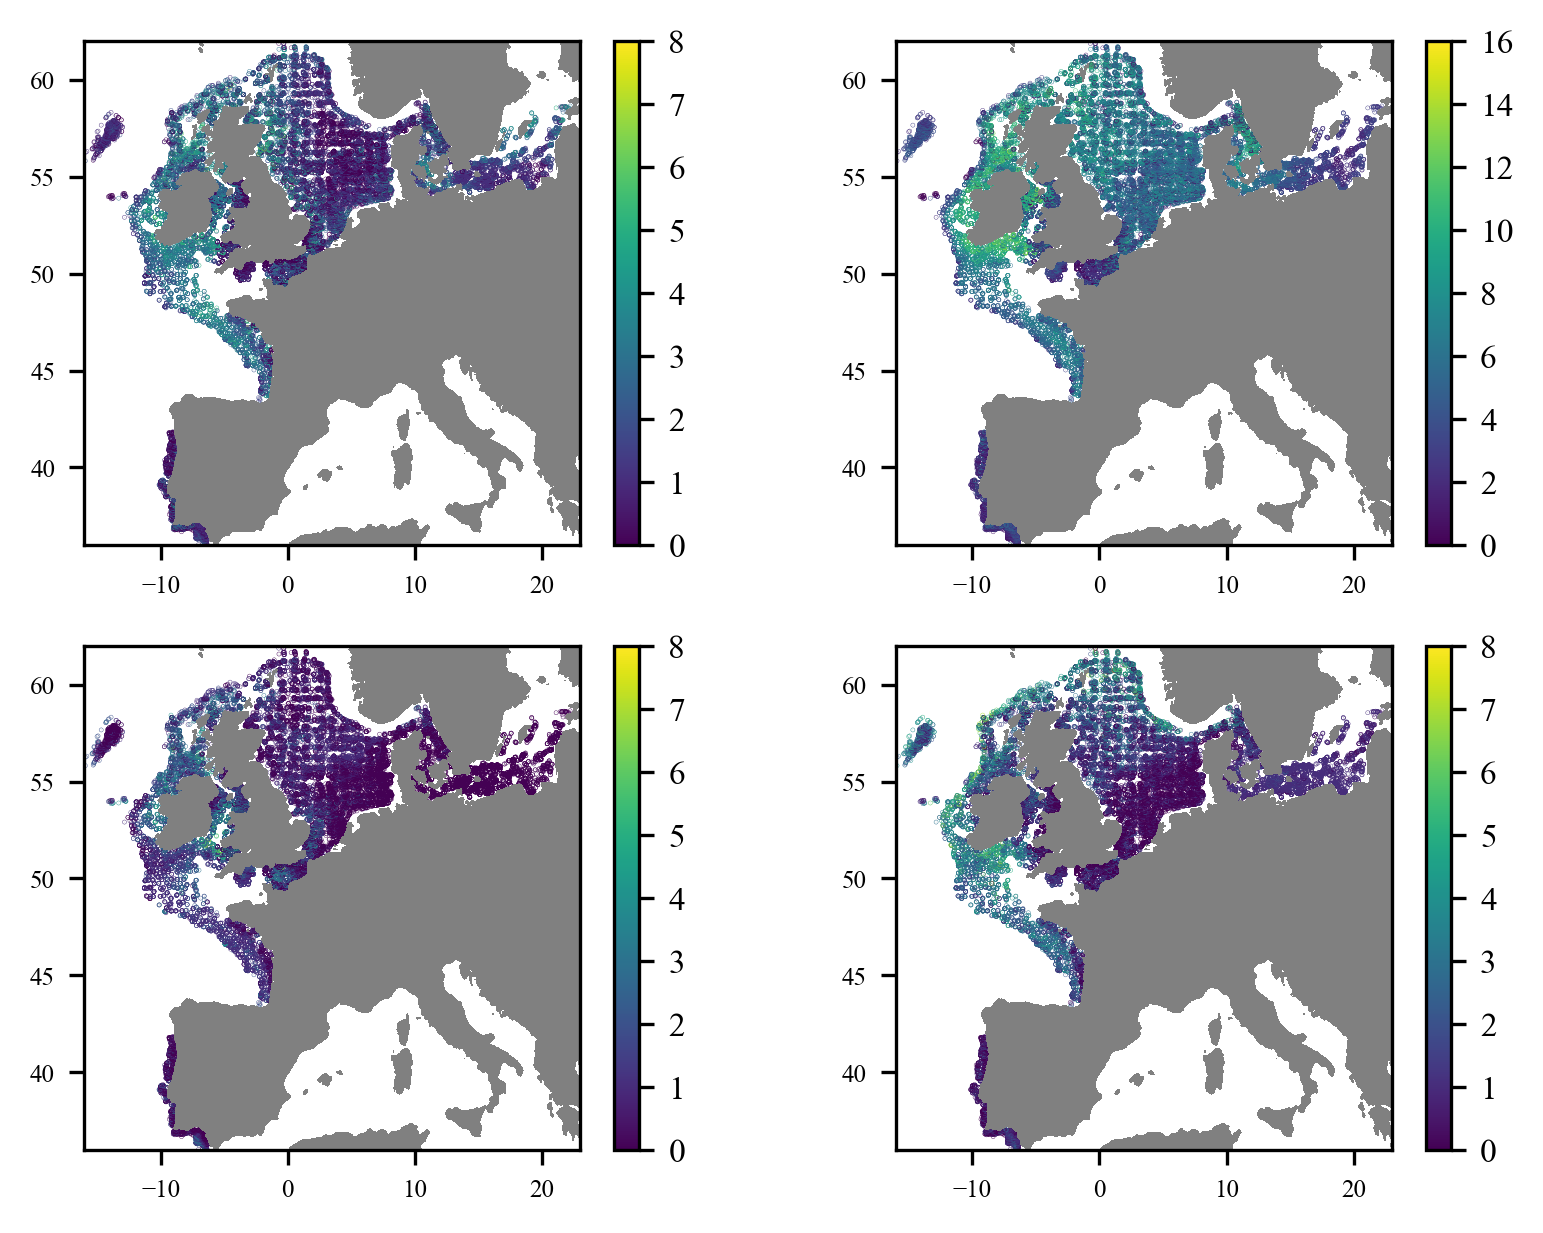

In [10]:
plot_fish_data(obslonS, obslatS, g1S, g2S, g3S, g4S)
PyPlot.savefig("../figures/fish_spatial_data.png", dpi=300, bbox_inches="tight")

## Spatial analysis
All the data are considered simultaneously, i.e. the year of measurement is not taken into account.      
We first transform the data.

In [59]:
g1log = log.(g1S .+ 1.);
g2log = log.(g2S .+ 1.);
g3log = log.(g3S .+ 1.);
g4log = log.(g4S .+ 1.);

### Parameter determination
#### Correlation length

In [12]:
"""
distbin = 0:.5:7.5;
mincount = 100;
var0,lenHori1,distx,covar,fitcovar = fit_isotropic((obslonS,obslatS),g1log .- mean(g1log),distbin,mincount);
var0,lenHori2,distx,covar,fitcovar = fit_isotropic((obslonS,obslatS),g2log .- mean(g2log),distbin,mincount);
var0,lenHori3,distx,covar,fitcovar = fit_isotropic((obslonS,obslatS),g3log .- mean(g3log),distbin,mincount);
var0,lenHori4,distx,covar,fitcovar = fit_isotropic((obslonS,obslatS),g4log .- mean(g4log),distbin,mincount);
@show lenHori1, lenHori2, lenHori3, lenHori4
"""

"distbin = 0:.5:7.5;\nmincount = 100;\nvar0,lenHori1,distx,covar,fitcovar = fit_isotropic((obslonS,obslatS),g1log .- mean(g1log),distbin,mincount);\nvar0,lenHori2,distx,covar,fitcovar = fit_isotropic((obslonS,obslatS),g2log .- mean(g2log),distbin,mincount);\nvar0,lenHori3,distx,covar,fitcovar = fit_isotropic((obslonS,obslatS),g3log .- mean(g3log),distbin,mincount);\nvar0,lenHori4,distx,covar,fitcovar = fit_isotropic((obslonS,obslatS),g4log .- mean(g4log),distbin,mincount);\n@show lenHori1, lenHori2, lenHori3, lenHori4\n"

#### Data weights
The weight is decreased for very close points.

In [13]:
rdiag=1.0./DIVAnd.weight_RtimesOne((obslonS,obslatS),(0.03,0.03))
@show maximum(rdiag),mean(rdiag)

(maximum(rdiag), mean(rdiag)) = (34.37624664581307, 7.5999287214601505)


(34.37624664581307, 7.5999287214601505)

#### Signal-to-noise ratio
We use the cross-validation tool for each of the 4 variables.

In [12]:
"""
epsilon2 = 0.02;
bestfactorl1,bestfactore1, cvval,cvvalues, x2Ddata,y2Ddata,cvinter,xi2D,yi2D = 
DIVAnd_cv(mmask[:,:,1],(pm,pn),(xi,yi),(obslonS,obslatS),g1log .- mean(g1log),lenHori1,epsilon2*rdiag,2,3);
@show bestfactorl1, bestfactore1
"""

"epsilon2 = 0.02;\nbestfactorl1,bestfactore1, cvval,cvvalues, x2Ddata,y2Ddata,cvinter,xi2D,yi2D = \nDIVAnd_cv(mmask[:,:,1],(pm,pn),(xi,yi),(obslonS,obslatS),g1log .- mean(g1log),lenHori1,epsilon2*rdiag,2,3);\n@show bestfactorl1, bestfactore1\n"

In [13]:
#epsilon2new = epsilon2 * bestfactore1

In [14]:
#lenHori1new = lenHori1 * bestfactorl1

The optimisation tools provide too small values for L and ε², leading to a noisy, unrealistic interpolated field.     
It is then prefered to fix those parameters.

In [14]:
len = 4.0
epsilon2 = 10.;

## Perform interpolation
### Analysis

In [15]:
@time 🐟1,s = DIVAnd.DIVAndrun(mmask[:,:,1],(pm,pn),(xi,yi),
    (obslonS,obslatS), g1log .- mean(g1log),len,epsilon2,alphabc=2);
@time 🐟2,s = DIVAnd.DIVAndrun(mmask[:,:,1],(pm,pn),(xi,yi),
    (obslonS,obslatS), g2log .- mean(g2log),len,epsilon2,alphabc=2);
@time 🐟3,s = DIVAnd.DIVAndrun(mmask[:,:,1],(pm,pn),(xi,yi),
    (obslonS,obslatS), g3log .- mean(g3log),len,epsilon2,alphabc=2);
@time 🐟4,s = DIVAnd.DIVAndrun(mmask[:,:,1],(pm,pn),(xi,yi),
    (obslonS,obslatS), g4log .- mean(g4log),len,epsilon2,alphabc=2);

 16.974129 seconds (42.64 M allocations: 2.965 GiB, 8.66% gc time)
  0.959348 seconds (1.74 M allocations: 999.540 MiB, 33.44% gc time)
  0.964599 seconds (1.73 M allocations: 999.305 MiB, 33.02% gc time)
  0.942772 seconds (1.72 M allocations: 998.472 MiB, 29.19% gc time)


### Error field
Using the CPME method.

In [16]:
🐟1_err = DIVAnd_cpme(mmask[:,:,1],(pm,pn),(xi,yi),(obslonS,obslatS),
    g1log .- mean(g1log),len,epsilon2,alphabc=2);
🐟2_err = DIVAnd_cpme(mmask[:,:,1],(pm,pn),(xi,yi),(obslonS,obslatS),
    g2log .- mean(g2log),len,epsilon2,alphabc=2);
🐟3_err = DIVAnd_cpme(mmask[:,:,1],(pm,pn),(xi,yi),(obslonS,obslatS),
    g3log .- mean(g3log),len,epsilon2,alphabc=2);
🐟4_err = DIVAnd_cpme(mmask[:,:,1],(pm,pn),(xi,yi),(obslonS,obslatS),
    g4log .- mean(g4log),len,epsilon2,alphabc=2);

### Write the netCDF with all the fields

In [17]:
function write_fish_nc(filename::String, gridlon, gridlat,
        field1::Array, field2::Array, field3::Array, field4::Array,
        err1::Array, err2::Array, err3::Array, err4::Array)

    Dataset(filename,"c") do ds

        nlon = length(gridlon);
        nlat = length(gridlat);

        # Define the dimension "lon" and "lat" with the size 100 and 110 resp.
        defDim(ds,"lon",nlon);
        defDim(ds,"lat",nlat);

        # Define a global attribute
        ds.attrib["title"] = "Interpolated Fish"

        # Define the variables and coordinates
        lon = defVar(ds,"lon",Float32,("lon",))
        lat = defVar(ds,"lat",Float32,("lat",))

        # Interpolated fields
        g1 = defVar(ds,"g1",Float64,("lon","lat"))
        g2 = defVar(ds,"g2",Float64,("lon","lat"))
        g3 = defVar(ds,"g3",Float64,("lon","lat"))
        g4 = defVar(ds,"g4",Float64,("lon","lat"))
      
        # Error fields
        g1_err = defVar(ds,"g1_err",Float64,("lon","lat"))
        g2_err = defVar(ds,"g2_err",Float64,("lon","lat"))
        g3_err = defVar(ds,"g3_err",Float64,("lon","lat"))
        g4_err = defVar(ds,"g4_err",Float64,("lon","lat"))

        # Fill the coord vectors and the fields
        lon[:] = gridlon;
        lat[:] = gridlat;

        g1[:,:] = field1;
        g2[:,:] = field2;
        g3[:,:] = field3;
        g4[:,:] = field4;

        g1_err[:,:] = err1;
        g2_err[:,:] = err2;
        g3_err[:,:] = err3;
        g4_err[:,:] = err4;

    end
end;

In [18]:
write_fish_nc("../output/Fish1.nc", gridlonFish, gridlatFish, 🐟1,🐟2,🐟3,🐟4,🐟1_err,🐟2_err,🐟3_err,🐟4_err);

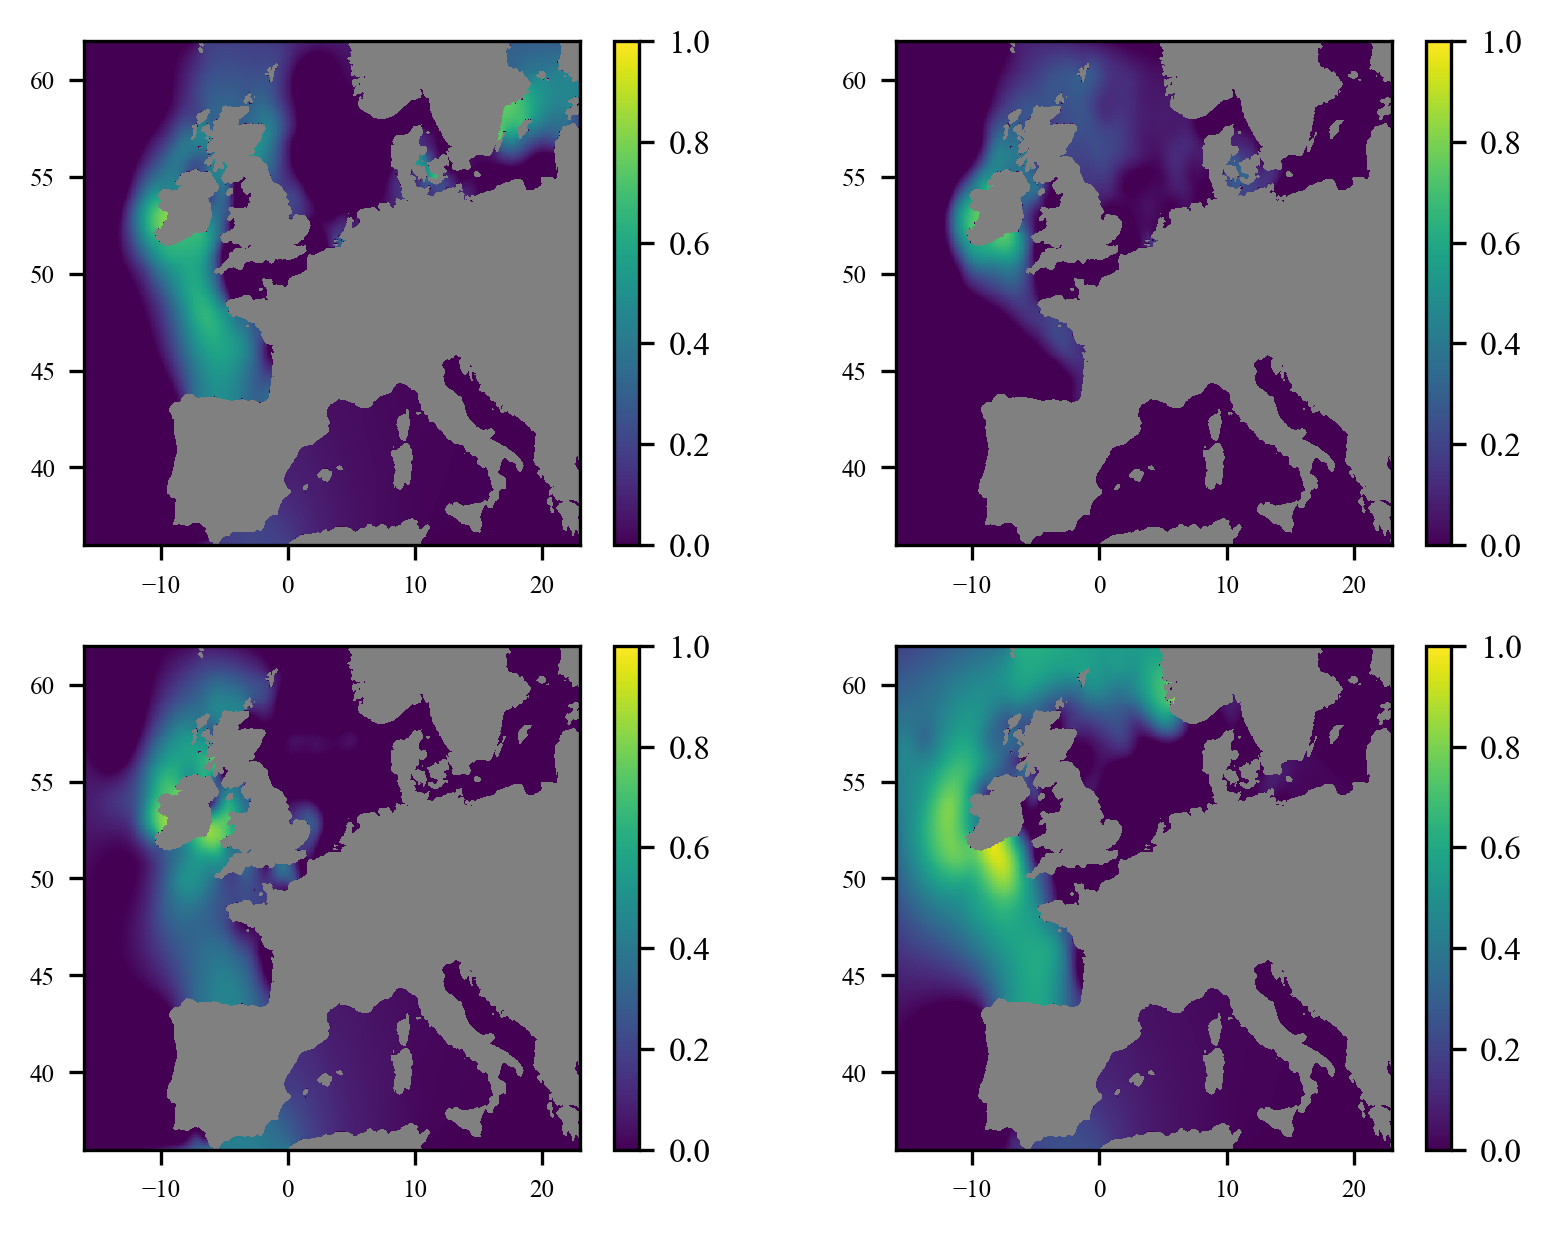

In [33]:
plot_fish_results(gridlonFish, gridlatFish, 🐟1,🐟2,🐟3,🐟4, bx, by, b)
PyPlot.savefig("../figures/fish_spatial_field.png", dpi=300, bbox_inches="tight")

## Temporal analysis
We work with 3-year periods ranging from 2000 to 2018.

In [42]:
datafileT = joinpath(fishdatadir, "Fish_temp_abs.csv");
@time obslonT, obslatT, obsyearT, g1T, g2T, g3T, g4T = read_fish(datafileT);

  1.035360 seconds (8.21 M allocations: 201.686 MiB, 15.04% gc time)


┌ Info: Working on a temporal data file
└ @ Main /home/ctroupin/ULg/Tools/DIVAndNN/src/make_fishs_products.jl:30
┌ Info: Number of data points: 37595
└ @ Main /home/ctroupin/ULg/Tools/DIVAndNN/src/make_fishs_products.jl:46


In [97]:
# Loop on the years
yearmin = 2000;
yearmax = 2018;
# Allocate arrays

nyears = length(yearmin:yearmax);
nlon = length(gridlonFish);
nlat = length(gridlatFish);

🐟1_time = Array{Float64, 3}(undef, (nyears, nlon, nlat));
🐟2_time = Array{Float64, 3}(undef, (nyears, nlon, nlat));
🐟3_time = Array{Float64, 3}(undef, (nyears, nlon, nlat));
🐟4_time = Array{Float64, 3}(undef, (nyears, nlon, nlat));

🐟1_err_time = Array{Float64, 3}(undef, (nyears, nlon, nlat));
🐟2_err_time = Array{Float64, 3}(undef, (nyears, nlon, nlat));
🐟3_err_time = Array{Float64, 3}(undef, (nyears, nlon, nlat));
🐟4_err_time = Array{Float64, 3}(undef, (nyears, nlon, nlat));

for (iy, yyyy) in enumerate(yearmin:yearmax)
    goodyears = (obsyearT .<= yyyy + 1) .& (obsyearT .>= yyyy - 1)
    @info "Number of observations for the year range $(yyyy-1)-$(yyyy+1): $(sum(goodyears))"
    # Select good data
    
    g1logT = log.(g1T[goodyears] .+ 1.)
    g2logT = log.(g2T[goodyears] .+ 1.)
    g3logT = log.(g3T[goodyears] .+ 1.)
    g4logT = log.(g4T[goodyears] .+ 1.)
    
    @time 🐟1,s = DIVAnd.DIVAndrun(mmask[:,:,1],(pm,pn),(xi,yi),
        (obslonT[goodyears],obslatT[goodyears]), g1logT .- mean(g1logT),len,epsilon2,alphabc=2);
    @time 🐟2,s = DIVAnd.DIVAndrun(mmask[:,:,1],(pm,pn),(xi,yi),
        (obslonT[goodyears],obslatT[goodyears]), g2logT .- mean(g2logT),len,epsilon2,alphabc=2);
    @time 🐟3,s = DIVAnd.DIVAndrun(mmask[:,:,1],(pm,pn),(xi,yi),
        (obslonT[goodyears],obslatT[goodyears]), g3logT .- mean(g3logT),len,epsilon2,alphabc=2);
    @time 🐟4,s = DIVAnd.DIVAndrun(mmask[:,:,1],(pm,pn),(xi,yi),
        (obslonT[goodyears],obslatT[goodyears]), g4logT .- mean(g4logT),len,epsilon2,alphabc=2);
    
    🐟1_time[iy,:,:] = 🐟1;
    🐟2_time[iy,:,:] = 🐟2;
    🐟3_time[iy,:,:] = 🐟3;
    🐟4_time[iy,:,:] = 🐟4;
    
    🐟1_err = DIVAnd_cpme(mmask[:,:,1],(pm,pn),(xi,yi),(obslonT[goodyears],obslatT[goodyears]),
        g1logT .- mean(g1logT),len,epsilon2,alphabc=2);
    🐟2_err = DIVAnd_cpme(mmask[:,:,1],(pm,pn),(xi,yi),(obslonT[goodyears],obslatT[goodyears]),
        g2logT .- mean(g2logT),len,epsilon2,alphabc=2);
    🐟3_err = DIVAnd_cpme(mmask[:,:,1],(pm,pn),(xi,yi),(obslonT[goodyears],obslatT[goodyears]),
        g3logT .- mean(g3logT),len,epsilon2,alphabc=2);
    🐟4_err = DIVAnd_cpme(mmask[:,:,1],(pm,pn),(xi,yi),(obslonT[goodyears],obslatT[goodyears]),
        g4logT .- mean(g4logT),len,epsilon2,alphabc=2);
    
    🐟1_err_time[iy,:,:] = 🐟1_err;
    🐟2_err_time[iy,:,:] = 🐟2_err;
    🐟3_err_time[iy,:,:] = 🐟3_err;
    🐟4_err_time[iy,:,:] = 🐟4_err;
    
end

┌ Info: Number of observations for the year range 1999-2001: 3125
└ @ Main In[97]:22


  0.831003 seconds (1.64 M allocations: 966.092 MiB, 37.90% gc time)
  0.852258 seconds (1.64 M allocations: 966.092 MiB, 36.44% gc time)
  0.944707 seconds (1.64 M allocations: 966.092 MiB, 36.16% gc time)
  0.901249 seconds (1.64 M allocations: 966.092 MiB, 37.00% gc time)


┌ Info: Number of observations for the year range 2000-2002: 4830
└ @ Main In[97]:22


  0.942907 seconds (1.65 M allocations: 967.015 MiB, 38.03% gc time)
  0.997066 seconds (1.65 M allocations: 967.015 MiB, 32.33% gc time)
  0.912875 seconds (1.65 M allocations: 967.015 MiB, 35.14% gc time)
  0.919495 seconds (1.65 M allocations: 967.015 MiB, 35.57% gc time)


┌ Info: Number of observations for the year range 2001-2003: 5201
└ @ Main In[97]:22


  0.879328 seconds (1.65 M allocations: 967.514 MiB, 35.90% gc time)
  0.880554 seconds (1.65 M allocations: 967.514 MiB, 35.28% gc time)
  0.899145 seconds (1.65 M allocations: 967.514 MiB, 35.17% gc time)
  0.888396 seconds (1.65 M allocations: 967.514 MiB, 35.29% gc time)


┌ Info: Number of observations for the year range 2002-2004: 5415
└ @ Main In[97]:22


  1.047507 seconds (1.65 M allocations: 967.773 MiB, 31.77% gc time)
  1.034669 seconds (1.65 M allocations: 967.773 MiB, 33.22% gc time)
  0.995367 seconds (1.65 M allocations: 967.773 MiB, 36.98% gc time)
  0.945307 seconds (1.65 M allocations: 967.773 MiB, 35.49% gc time)


┌ Info: Number of observations for the year range 2003-2005: 5555
└ @ Main In[97]:22


  0.902773 seconds (1.66 M allocations: 967.990 MiB, 35.19% gc time)
  0.877069 seconds (1.66 M allocations: 967.990 MiB, 35.48% gc time)
  0.886521 seconds (1.66 M allocations: 967.990 MiB, 35.23% gc time)
  0.888280 seconds (1.66 M allocations: 967.990 MiB, 35.21% gc time)


┌ Info: Number of observations for the year range 2004-2006: 5547
└ @ Main In[97]:22


  0.888423 seconds (1.66 M allocations: 968.024 MiB, 35.72% gc time)
  0.878161 seconds (1.66 M allocations: 968.024 MiB, 34.92% gc time)
  0.921135 seconds (1.66 M allocations: 968.024 MiB, 34.18% gc time)
  0.912803 seconds (1.66 M allocations: 968.024 MiB, 35.31% gc time)


┌ Info: Number of observations for the year range 2005-2007: 5602
└ @ Main In[97]:22


  0.893074 seconds (1.66 M allocations: 968.094 MiB, 35.51% gc time)
  0.904922 seconds (1.66 M allocations: 968.094 MiB, 35.02% gc time)
  0.863669 seconds (1.66 M allocations: 968.094 MiB, 35.88% gc time)
  0.878092 seconds (1.66 M allocations: 968.094 MiB, 35.49% gc time)


┌ Info: Number of observations for the year range 2006-2008: 5719
└ @ Main In[97]:22


  1.034688 seconds (1.66 M allocations: 968.244 MiB, 33.51% gc time)
  0.993010 seconds (1.66 M allocations: 968.244 MiB, 35.76% gc time)
  0.862197 seconds (1.66 M allocations: 968.244 MiB, 36.88% gc time)
  0.908077 seconds (1.66 M allocations: 968.244 MiB, 34.44% gc time)


┌ Info: Number of observations for the year range 2007-2009: 5921
└ @ Main In[97]:22


  0.843272 seconds (1.66 M allocations: 968.452 MiB, 36.93% gc time)
  0.845980 seconds (1.66 M allocations: 968.452 MiB, 36.42% gc time)
  0.843550 seconds (1.66 M allocations: 968.452 MiB, 36.49% gc time)
  0.959963 seconds (1.66 M allocations: 968.452 MiB, 34.67% gc time)


┌ Info: Number of observations for the year range 2008-2010: 5965
└ @ Main In[97]:22


  0.841593 seconds (1.66 M allocations: 968.467 MiB, 36.72% gc time)
  0.878534 seconds (1.66 M allocations: 968.467 MiB, 35.17% gc time)
  0.867080 seconds (1.66 M allocations: 968.467 MiB, 36.64% gc time)
  0.864645 seconds (1.66 M allocations: 968.467 MiB, 36.39% gc time)


┌ Info: Number of observations for the year range 2009-2011: 6148
└ @ Main In[97]:22


  0.848343 seconds (1.66 M allocations: 968.764 MiB, 36.96% gc time)
  0.893969 seconds (1.66 M allocations: 968.764 MiB, 34.99% gc time)
  0.947919 seconds (1.66 M allocations: 968.764 MiB, 33.93% gc time)
  0.877919 seconds (1.66 M allocations: 968.764 MiB, 36.12% gc time)


┌ Info: Number of observations for the year range 2010-2012: 6676
└ @ Main In[97]:22


  0.893031 seconds (1.66 M allocations: 969.549 MiB, 38.35% gc time)
  0.910907 seconds (1.66 M allocations: 969.549 MiB, 36.42% gc time)
  0.954611 seconds (1.66 M allocations: 969.549 MiB, 34.05% gc time)
  0.988114 seconds (1.66 M allocations: 969.549 MiB, 34.29% gc time)


┌ Info: Number of observations for the year range 2011-2013: 7311
└ @ Main In[97]:22


  0.916662 seconds (1.67 M allocations: 970.422 MiB, 35.03% gc time)
  0.902220 seconds (1.67 M allocations: 970.422 MiB, 35.23% gc time)
  0.909398 seconds (1.67 M allocations: 970.422 MiB, 34.71% gc time)
  0.892345 seconds (1.67 M allocations: 970.422 MiB, 35.47% gc time)


┌ Info: Number of observations for the year range 2012-2014: 7660
└ @ Main In[97]:22


  0.871990 seconds (1.67 M allocations: 970.827 MiB, 36.47% gc time)
  0.945183 seconds (1.67 M allocations: 970.827 MiB, 33.26% gc time)
  0.876505 seconds (1.67 M allocations: 970.827 MiB, 35.59% gc time)
  0.864195 seconds (1.67 M allocations: 970.827 MiB, 36.63% gc time)


┌ Info: Number of observations for the year range 2013-2015: 7682
└ @ Main In[97]:22


  0.942935 seconds (1.67 M allocations: 970.851 MiB, 36.57% gc time)
  0.888498 seconds (1.67 M allocations: 970.851 MiB, 35.76% gc time)
  1.005334 seconds (1.67 M allocations: 970.851 MiB, 35.30% gc time)
  1.036998 seconds (1.67 M allocations: 970.851 MiB, 34.98% gc time)


┌ Info: Number of observations for the year range 2014-2016: 7766
└ @ Main In[97]:22


  1.126337 seconds (1.67 M allocations: 970.981 MiB, 33.15% gc time)
  1.064530 seconds (1.67 M allocations: 970.981 MiB, 35.00% gc time)
  1.129604 seconds (1.67 M allocations: 970.981 MiB, 32.61% gc time)
  1.056216 seconds (1.67 M allocations: 970.981 MiB, 36.35% gc time)


┌ Info: Number of observations for the year range 2015-2017: 7683
└ @ Main In[97]:22


  0.850307 seconds (1.67 M allocations: 970.806 MiB, 36.98% gc time)
  0.866329 seconds (1.67 M allocations: 970.806 MiB, 36.24% gc time)
  0.859021 seconds (1.67 M allocations: 970.806 MiB, 36.49% gc time)
  0.848844 seconds (1.67 M allocations: 970.806 MiB, 36.55% gc time)


┌ Info: Number of observations for the year range 2016-2018: 5095
└ @ Main In[97]:22


  0.851964 seconds (1.65 M allocations: 969.027 MiB, 36.89% gc time)
  0.853719 seconds (1.65 M allocations: 969.027 MiB, 37.71% gc time)
  0.872503 seconds (1.65 M allocations: 969.027 MiB, 36.99% gc time)
  0.867839 seconds (1.65 M allocations: 969.027 MiB, 36.24% gc time)


┌ Info: Number of observations for the year range 2017-2019: 2411
└ @ Main In[97]:22


  0.874316 seconds (1.64 M allocations: 965.189 MiB, 37.19% gc time)
  0.891651 seconds (1.64 M allocations: 965.189 MiB, 36.72% gc time)
  0.945285 seconds (1.64 M allocations: 965.189 MiB, 36.97% gc time)
  0.947643 seconds (1.64 M allocations: 965.189 MiB, 38.46% gc time)


In [111]:
function plot_fish_results_time(years,gridlon, gridlat, f1, bx, by, b)
    
    yearinit = collect(years) .-1;
    yearinit[1] = yearinit[2];
    yearend = collect(years) .+ 1;
    yearend[end] = yearend[end-1]
    
    ffig = figure("fish_time",figsize=(12,12))
    for ii = 1:size(f1)[1]
        ax = subplot(5,4,ii)
        title("$(yearinit[ii])-$(yearend[ii])", fontsize=8)
        ax[:tick_params]("both",labelsize=6)
        pcm = PyPlot.pcolormesh(gridlon, gridlat, permutedims(f1[ii,:,:], [2,1]), vmin=0, vmax=1.)
        add_mask(bx, by, b)
        gca()[:set_aspect](1/cos(mean([ylim()...]) * pi/180))
        colorbar(pcm)[:ax][:tick_params](labelsize=8)
    end
end

plot_fish_results_time (generic function with 2 methods)

In [112]:
plot_fish_results_time(2000:2018,gridlonFish, gridlatFish, 🐟1_time, bx, by, b);
PyPlot.savefig("../figures/fish_time01.png", dpi=300, bbox_inches="tight")
PyPlot.close_figs()
plot_fish_results_time(2000:2018,gridlonFish, gridlatFish, 🐟2_time, bx, by, b);
PyPlot.savefig("../figures/fish_time02.png", dpi=300, bbox_inches="tight")
PyPlot.close_figs()
plot_fish_results_time(2000:2018,gridlonFish, gridlatFish, 🐟3_time, bx, by, b);
PyPlot.savefig("../figures/fish_time03.png", dpi=300, bbox_inches="tight")
PyPlot.close_figs()
plot_fish_results_time(2000:2018,gridlonFish, gridlatFish, 🐟4_time, bx, by, b);
PyPlot.savefig("../figures/fish_time04.png", dpi=300, bbox_inches="tight")
PyPlot.close_figs()